# Implementation : Variational Coin Toss

# Variational Inference

### tip) Bayesian approach
$$p(H|D) = \frac{P(H) * P(D|H)}{P(D)}$$

$$posterior = \frac{(prior) * (likelihood)}{evidence}$$

### Our Model
$$p(z|x) = \frac{p(z) * p(x|z)}{p(x)}$$


- 사후확률 분포 $p(z|x)$를 다루기 쉬운 확률분포 $q(z)$로 approximation하는 방법을 말함. 사후확률 분포를 계산하는게 불가능에 가까울 정도로 어려운 경우가 많기 때문임. 어려운 예시

    1. marginal probabilty, 즉 사후확률의 분모인 $p(x) = \sum_z p(x, z)$를 계산하기 어려운 경우
    2. likelihood, 즉 $p(x|z)$를 복잡하게 모델링하고자 하는 경우
    3. prior, 즉 $p(z)$를 복잡하게 모델링하고자 하는 경우

## 3. Conjugate distribution
- 동전던지기 실험은 **이항분포**를 따름. 이항분포란 성공확률이 $p$이고, 그 결과가 성공 혹은 실패뿐인 실험을 $n$번 반복실험할 때 성공횟수의 분포를 가르킴. 이항분포 파라미터 $p$의 사전확률과 사후확률 모두 베타분포를 따름. 
- 사전확률 분포와 사후확률 분포가 같은 가족군으로 묶일 때 그 사후확률/사전확률을 모두 묶어 **켤레분포(conjugate distribution)**라고 함.

- q(z)를 $\alpha_q$, $\beta_q$를 파라미터로 하는 베타분포, 앞면이 관측된 수를 $n_h$, 뒷면을 $n_t$로 두었을 때. 이를 아래 식에 대입해서 풀면 사후확률 분포 $p(z|x)$에 가장 잘 근사한 $q(z)$는 $\alpha_q + n_h$, $\beta_q + n_t$를 파라미터로 하는 베타분포가 된다고 함.

## 1. Import Libs

In [1]:
import numpy as np
import scipy.stats as scs
import scipy.special as scf
import scipy.optimize as sco
np.random.seed(733)

import matplotlib
import matplotlib.pyplot as plt

### Ploting example for Beta distribution

In [2]:
z_space = np.linspace(0, 1, 250)
p_z = scs.beta(3, 3).pdf(z_space)  # "p_z" is Beta[3, 3] distribution 

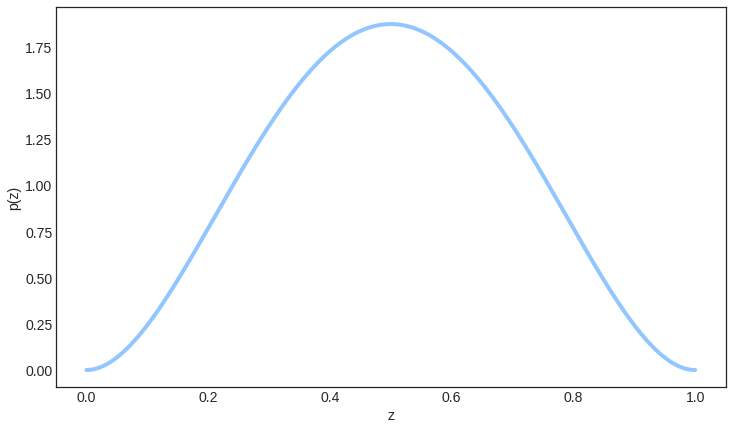

In [3]:
matplotlib.rcParams.update({'font.size': 14})
plt.style.use(['seaborn-pastel', 'seaborn-white'])
plt.figure(figsize=(12, 7))
plt.plot(z_space, p_z, linewidth=4.)
plt.xlabel('z')
plt.ylabel('p(z)')
plt.show()

### Generate some data from the generative model for our experiment
- A True Beta Prior : p(z) = Beta(3,3) and Bernoulli Likelihood p(x|z)
- we actually sample some data $x$ for the experiment

In [4]:
# 기억할 점 : 베르누이 시행은 베타분포로 나타남
true_z = scs.beta.rvs(3, 3) # 확률값을 리턴
x = scs.bernoulli.rvs(true_z, size=30)
print("z = ", true_z)
print("x = ", x)

z =  0.27205213533603445
x =  [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0]


### Define KL divergence between Beta and Beta
we also define expected log bernoulli likelihood with respect to Beta Distribution

## KL-Divergence
- 사후확률에 근사한 $q(z)$를 만들기 위해서 **kullback-Leibler Divergence(KLD)**개념을 활용
- KLD는 두 확률분포의 차이를 계산하는 데 사용하는 함수. 사후확률 분포 $p(z|x)$(사후확률)과 $q(z)$ 사이의 KLD를 계산하고, KLD가 줄어드는 쪽으로 $q(z)$를 조금씩 업데이트하는 과정을 반복하면 사후확률을 근사하는 $q^*(z)$를 얻게 될 것이라는 게 Variational Inference의 핵심 아이디어임. 

$$D_{KL}(q(z)||p(z|x)) = \int q(z) \text{log} \frac{q(z)}{p(z|x)} dx$$

$$= \int q(z) \text{log} \frac{q(z) p(x)}{p(z|x) p(z)} dx$$

$$= \int q(z) \text{log} \frac{q(z)}{p(z)} dx + \int q(z) \text{log}p(x) dx - \int q(z) \text{log}p(x|z) dx$$

$$= D_{KL} (q(z) || p(z)) + \text{log} p(x) - E_{z \sim q(z)} [\text{log}p(x|z)]$$

In [5]:
def KL(a2, b2, a1, b1):
    """Returns the Kullback-Leibler divergence between Beta[a2, b2] and Beta[a1, b1]"""
    #print "KL(Beta[3, 3] || Beta[1, 1]) = ", KL(3, 3, 1, 1)
    #print "KL(Beta[.5,3] || Beta[3,.5]) = ", KL(0.5, 3, 3, 0.5)
    return (np.log(scf.beta(a1, b1) / scf.beta(a2, b2)) + (a2 - a1) * scf.psi(a2) + (b2 - b1) * scf.psi(b2) +
            (a1 - a2 + b1 - b2) * scf.psi(a2 + b2))

def E_log_p_x_z(x, a2, b2):
    """Returns the expected value of log p(x | z) over z ~ Beta[a2, b2]"""
    return ((x == 1).sum() * (scf.psi(a2) - scf.psi(a2 + b2)) +
            (x == 0).sum() * (scf.psi(b2) - scf.psi(a2 + b2)))

## Analytical KL divergence objective KL(q(z)|p(z|x))

In [6]:
def objective(a2b2):
    return (KL(a2b2[0],a2b2[1],3,3)-E_log_p_x_z(x,a2b2[0],a2b2[1]))

q_trace = [p_z] # array([x1, ...]) # len:250

res = sco.minimize(objective, [3,3], callback=lambda a2b2: q_trace.append(scs.beta(a2b2[0], a2b2[1]).pdf(z_space)))
print(res.message)

Optimization terminated successfully.


# Animation

In [7]:
from matplotlib import animation

def generate_animation(qs):
    # True Posterior distribution P(z|x) = beta(3 + n(x=1), 3 + n(x=0))
    p_z_x = scs.beta(3 + (x == 1).sum(), 3 + (x == 0).sum()).pdf(z_space)

    # animation code step
    fig = plt.figure(figsize=(12, 7))
    ax = plt.axes(xlim=(0,1), ylim=(0, 1.1 * p_z_x.max()))
    ax.set_xlabel('z')

    # Ploting initial Prior distribution P(z) and true Posterior distribution P(z|x)
    ax.plot(z_space, p_z, linewidth=4, label = 'p(z)')
    ax.plot(z_space, p_z_x, linewidth=4, linestyle='--', dashes=(5, 1), label = 'p(z|x)')

    # legend
    approx, = ax.plot([], [], linewidth=2., label = 'q(z)')
    ax.legend(loc=2 if (x == 1).sum() >= (x == 0).sum() else 1)

    # Ploting estimation : Q(z) Distribution
    def init():
        approx.set_data([], [])
        return approx,

    # animation function. This is calling sequencially
    def animate(i):
        if i >= len(qs):
            i = len(qs) - 1
        approx.set_data(z_space, qs[i])
        return approx,
    interval = 1000 * 15 // len(qs)
    
    # call the animator. blit=True menas only re-draw the parts that have chaged
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=(len(qs) + (5000 // interval)), interval=interval, blit=True)
    plt.close()
    
    return anim.to_html5_video()

In [8]:
from IPython.display import HTML
html = generate_animation(q_trace)

with open("variational_coin_closedform.html", 'w') as f:
    f.write(html)

HTML(html)

## Monte Carlo Approximation of KL(q(z)||p(z|x))

## Variational Inference with Monte Carlo sampling
- 랜덤 표본을 뽑아 함수의 값을 확률적으로 계산하는 알고리즘. **닫힌 형식(closed form)**으로 표현되지 않거나 복잡한 경우에 그 값을 근사적으로 계산하려고 할 때 사용. 예를들어 확률 분포를 따르는 x의 함수값의 기대값은 다음과 같이 k개 샘플로 근사하는 것임

$$\int p(x) \ f(x) \ dx = E_{x \sim p(x)} [f(x)] \approx \frac{1}{K} \sum_{i=0}^K [f(x_i)]_{x_i \sim p(x)}$$

- 몬테카를로 방법은 KLD에 적용해서 식을 정리하면 아래와 같음

$$D_{KL}(q(z)\| p(z|x))= D_{KL} (q(z) || p(z)) + \text{log} p(x) - E_{z \sim q(z)} [\text{log}p(x|z)]$$

$$= E_{z \sim q(z)} \big[ \text{log}\  \frac{q(z)}{p(z)} \big] + \text{log} p(x) - E_{z \sim q(z)} [\text{log} p(x|z)] $$

$$\approx \frac{1}{K} \sum_{i=0}^K \big[\text{log} \frac{q(z_i)}{p(z_i)} \big]_{z_i \sim q(z)} + \text{log} p(x) - \frac{1}{K} \sum_{i=0}^K [\text{log} p(x|z_{i}) ]_{z_i \sim q(z)}$$

$$= \frac{1}{K} \sum_{i=0}^K [ \text{log}\ q(z_i) - \text{log} \ p(z_i) - \text{log} \  p(x|z_i) ]_{z_i \sim q(z)} + \text{log} \  p(x) $$

- 이렇게 되면 $q(z)$를 설정하는 것이 자유롭게 됨. 동전던지기 예제에서는 $q(z)$를 베타분포로 정하는 것이 자연스럽지만, 실제 문제에서는 사후확률 분포에 대해 아무런 정보가 없기 때문에 이렇게 VI를 진행하기가 어려움. 하지만 몬테카를로 방법을 이용하게 된다면 $q(z)$를 **어떤 분포**든 사용할 수 있게 됨

- 사후분포에 대한 정보가 없어서 $q(z)$를 정규분포로 정하고 그 정규분포에서 $k$개의 $z$를 봅으면 KLD의 근사값을 계산할 수 있음. 정규분포의 모수는 평균과 분산이기 때문에 이들은 조금씩 바꾸면서 KLD의 근사값을 최소로 모수룰 구할 수 있게 됨. 이 결과물이 Variational Inference의 결과

In [9]:
eps = np.finfo(np.float32).eps
N = 10000                            # number of sample 10000:

def monte_carlo_estimate(a2b2):
    """Returns an estimate of the objective based on Monte Carlo integration"""
    if a2b2[0] < 0.0 or a2b2[1] < 0.0:
        return np.inf
    
    p = scs.beta(3, 3)               # p(z;3,3)
    q = scs.beta(a2b2[0], a2b2[1])   # q(z; parm1, parm2) 
    s_z = q.rvs(size=N)              # n z ~ q(z; parm1, parm2)

    s_p_z = p.pdf(s_z) + eps         # pdf value p(z_i)
    s_q_z = q.pdf(s_z) + eps         # pdf value q(z_i)
            
    return (1. / N) * (np.log(s_q_z / s_p_z) - (x == 1).sum() * np.log(s_z) - (x == 0).sum() * np.log(1 - s_z)).sum()


q_trace = [p_z]
res = sco.minimize(monte_carlo_estimate, [3,3], method='Powell', callback=lambda a2b2: q_trace.append(scs.beta(a2b2[0], a2b2[1]).pdf(z_space)))

print(res.message)

/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/scipy/optimize/optimize.py:1929: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


Optimization terminated successfully.


In [10]:
from IPython.core.display import HTML
html = generate_animation(q_trace)
with open('variational_coin_mcint.html', 'w') as f:
    f.write(html)
HTML(html)

# Stochastic Variational Inference with Reparameterization

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(733)

def gammaln(x):
    value = Variable(torch.Tensor([0]))
    for i in torch.arange(x)[1:]:
        value += Variable(torch.log(torch.Tensor([i])))
    return value

def log_gaussian_logsigma(x, mu, logsigma):
    return -.5 * torch.log(2 * Variable(torch.Tensor([np.pi])) - q_logsigma - (x - q_logsigma) ** 2 / (2. * torch.exp(2. * q_logsigma)))

def log_beta(x, a, b):
    return (a - 1) * torch.log(x) + (b - 1) * torch.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))

In [12]:
prior_a, prior_b = 3, 3 # (3, 3) (2,2) (3, 1) => 파라미터는 실험적으로 접근해야함
q_mu = Variable(torch.Tensor([float(prior_a) / (prior_a + prior_b)]), requires_grad=True)
q_logsigma = Variable(torch.Tensor([0.5 * np.log(float(prior_a * prior_b) / ((prior_a + prior_b)**2 * (prior_a + prior_b + 1)))]), requires_grad=True)

optimizer = optim.RMSprop([q_mu,q_logsigma], lr=0.01)
#optimizer = optim.Adam([q_mu,q_logsigma], lr=0.01)
#optimizer = optim.SGD([q_mu,q_logsigma], lr=0.01)

def KL_cost_fn(q_mu,q_logsigma,n_samples=10):
    KL_objective = Variable(torch.zeros(1))

    for sample in range(n_samples):    
        sample_z = q_mu + torch.exp(q_logsigma) * Variable(torch.randn(1))
        log_q_z = log_gaussian_logsigma(sample_z, q_mu, q_logsigma)
        log_p_z = log_beta(sample_z, prior_a, prior_b)
        log_p_x_z = Variable(torch.Tensor([int((x == 1).sum())])) * torch.log(sample_z) \
                  + Variable(torch.Tensor([int((x == 0).sum())])) * torch.log(1 - sample_z)
        
        KL_objective += (log_q_z - log_p_z - log_p_x_z).sum() / n_samples
    return KL_objective 


q_trace = [scs.norm(q_mu.data.numpy(), np.exp(q_logsigma.data.numpy())).pdf(z_space)]

for epoch in range(250):
    cost = KL_cost_fn(q_mu,q_logsigma) 
    cost.backward()                     # compute gradient value of parameters (q_mu, q_logsigma)
    optimizer.step()                    # update gradients !! 
    optimizer.zero_grad()               # clear gradients for next traing

    q_trace.append(scs.norm(q_mu.data.numpy(), np.exp(q_logsigma.data.numpy())).pdf(z_space))

In [13]:
html = generate_animation(q_trace)
with open('variational_coin_sgd.html', 'w') as f:
    f.write(html)
    
HTML(html)